In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import cv2
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [2]:
#os.getcwd()

'/Users/davislab'

In [ ]:
#!unzip "/content/gdrive/MyDrive/archive.zip" -d "/content/gdrive/MyDrive/traffic_data"

In [3]:
train_path = '/Users/davislab/Downloads/archive/Train'
test_path = '/Users/davislab/Downloads/archive/Test'
train_path

'/Users/davislab/Downloads/archive/Train'

In [4]:
num_classes= len(os.listdir(train_path))
num_classes

43

In [6]:
train_images=[]
labels=[]
for i in range(num_classes):
    path=os.path.join(train_path,str(i))
    print(path)
    images=os.listdir(path)
    for image in images:
        try:
            image=Image.open(path+'/'+image)
            image=image.resize((32,32))
            train_images.append(np.array(image))
            labels.append(i)
        except AttributeError:
            print("Error",image)

/Users/davislab/Downloads/archive/Train/0
/Users/davislab/Downloads/archive/Train/1
/Users/davislab/Downloads/archive/Train/2
/Users/davislab/Downloads/archive/Train/3
/Users/davislab/Downloads/archive/Train/4
/Users/davislab/Downloads/archive/Train/5
/Users/davislab/Downloads/archive/Train/6
/Users/davislab/Downloads/archive/Train/7
/Users/davislab/Downloads/archive/Train/8
/Users/davislab/Downloads/archive/Train/9
/Users/davislab/Downloads/archive/Train/10
/Users/davislab/Downloads/archive/Train/11
/Users/davislab/Downloads/archive/Train/12
/Users/davislab/Downloads/archive/Train/13
/Users/davislab/Downloads/archive/Train/14
/Users/davislab/Downloads/archive/Train/15
/Users/davislab/Downloads/archive/Train/16
/Users/davislab/Downloads/archive/Train/17
/Users/davislab/Downloads/archive/Train/18
/Users/davislab/Downloads/archive/Train/19
/Users/davislab/Downloads/archive/Train/20
/Users/davislab/Downloads/archive/Train/21
/Users/davislab/Downloads/archive/Train/22
/Users/davislab/Downl

# Input image processing for Resnet and CNN models

In [7]:
train_images=np.array(train_images)
labels=np.array(labels)

In [8]:
train_images.shape, labels.shape

((39209, 32, 32, 3), (39209,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.2, random_state=42, shuffle=True)

In [10]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((31367, 32, 32, 3), (7842, 32, 32, 3), (31367,), (7842,))

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, 43)
y_val = tf.keras.utils.to_categorical(y_val,43)

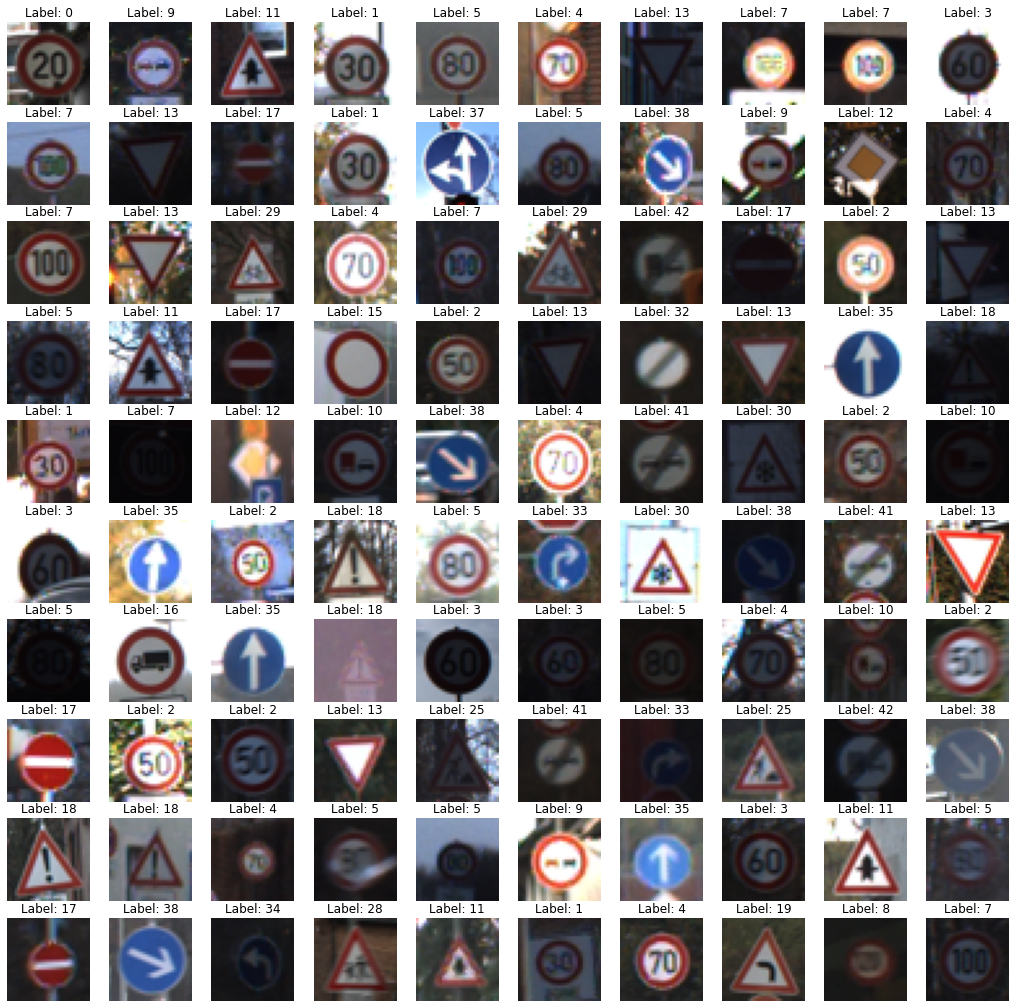

In [12]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_train.shape[0])
    ax.imshow(X_train[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y_train[r])))

In [17]:
img_shape=X_train[0].shape
img_shape

(32, 32, 3)

In [74]:
def createCNNsimplemodel(name, numclasses, img_shape, metrics=['accuracy']):
    #img_shape (img_height, img_width, 3)
    if name=='mobilenetmodel1':
        return create_mobilenetmodel1(numclasses, img_shape, metrics)
    elif name=='xceptionmodel1':
        return create_Xceptionmodel1(numclasses, img_shape, metrics)
    elif name=='resnet':
        return create_resnet(numclasses, img_shape, metrics)

In [75]:
def create_resnet(numclasses, img_shape, metrics=['accuracy']):
    pretrained_model = tf.keras.applications.ResNet50(input_shape=img_shape, include_top=False, weights='imagenet')
    pretrained_model.trainable = False #True

    model = tf.keras.Sequential([
        pretrained_model,
        #tf.keras.layers.Flatten(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(numclasses, activation='softmax')
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.GlobalAveragePooling2D(),
        # tf.keras.layers.Dense(numclasses, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        #loss = 'sparse_categorical_crossentropy',
        metrics=metrics
    )

    return model

# Model 1: Resnet50

In [76]:
model=createCNNsimplemodel('resnet', num_classes, img_shape, metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 43)                88107     
Total params: 23,675,819
Trainable params: 88,107
Non-trainable params: 23,587,712
_________________________________________________________________


In [78]:
def learningratefn(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

def plot_history(history, metric, val_metric):
    acc = history.history[metric]
    val_acc = history.history[val_metric]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([min(plt.ylim()), 1])
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()
    fig.savefig('traininghistory.pdf')

In [79]:
checkpoint_dir = "/Users/davislab/Downloads/archive/outputs" #'./training_checkpoints'
    # Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
log_dir= "/Users/davislab/Downloads/archive/outputs"

callbacks = [tf.keras.callbacks.TensorBoard(log_dir),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
             tf.keras.callbacks.LearningRateScheduler(learningratefn),
             PrintLR()]

In [80]:
import time
start_time = time.time()
#train the model 
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=32, epochs=30, callbacks=callbacks)

Epoch 1/30
981/981 [==============================] - 51s 50ms/step - loss: 4.3266 - accuracy: 0.3005 - val_loss: 1.2215 - val_accuracy: 0.6408

Learning rate for epoch 1 is 0.0010000000474974513
Epoch 2/30
981/981 [==============================] - 52s 53ms/step - loss: 1.6931 - accuracy: 0.5519 - val_loss: 1.1204 - val_accuracy: 0.6639

Learning rate for epoch 2 is 0.0010000000474974513
Epoch 3/30
981/981 [==============================] - 51s 52ms/step - loss: 1.4783 - accuracy: 0.6023 - val_loss: 1.0116 - val_accuracy: 0.7011

Learning rate for epoch 3 is 0.0010000000474974513
Epoch 4/30
981/981 [==============================] - 52s 53ms/step - loss: 1.1649 - accuracy: 0.6641 - val_loss: 0.7449 - val_accuracy: 0.7675

Learning rate for epoch 4 is 9.999999747378752e-05
Epoch 5/30
981/981 [==============================] - 51s 52ms/step - loss: 1.0358 - accuracy: 0.6855 - val_loss: 0.7339 - val_accuracy: 0.7753

Learning rate for epoch 5 is 9.999999747378752e-05
Epoch 6/30
981/981 [

In [84]:
loss, acc = model.evaluate(X_val, y_val)
print('Accuracy: ', acc, '\nLoss    : ', loss)

246/246 [==============================] - 9s 37ms/step - loss: 0.6577 - accuracy: 0.8008
Accuracy:  0.8008161187171936 
Loss    :  0.657720685005188


In [85]:
y_test =pd.read_csv("/Users/davislab/Downloads/archive/Test.csv")
test_labels = y_test['Path'].values
y_test = y_test['ClassId'].values

In [86]:
test_images=[]
folder="/Users/davislab/Downloads/archive/"
for i in test_labels:
    image=Image.open(folder+str(i))
    image=image.resize((32,32))
    test_images.append(np.array(image))

In [94]:
X_test=np.array(test_images)
pred = np.argmax(model.predict(X_test), axis = 1)

In [95]:
pred

array([16,  1, 38, ...,  5,  9, 10])

In [99]:
accuracy_score(y_test, pred)

0.4953285827395091

# Model 2: CNN 

In [101]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [102]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 30, validation_data=(X_val, y_val))

Epoch 1/30
981/981 [==============================] - 33s 33ms/step - loss: 3.3127 - accuracy: 0.3752 - val_loss: 0.2801 - val_accuracy: 0.9262
Epoch 2/30
981/981 [==============================] - 32s 33ms/step - loss: 0.5119 - accuracy: 0.8496 - val_loss: 0.1110 - val_accuracy: 0.9679
Epoch 3/30
981/981 [==============================] - 33s 34ms/step - loss: 0.3184 - accuracy: 0.9097 - val_loss: 0.0854 - val_accuracy: 0.9769
Epoch 4/30
981/981 [==============================] - 34s 34ms/step - loss: 0.2366 - accuracy: 0.9318 - val_loss: 0.0780 - val_accuracy: 0.9792
Epoch 5/30
981/981 [==============================] - 33s 34ms/step - loss: 0.2107 - accuracy: 0.9403 - val_loss: 0.0905 - val_accuracy: 0.9802
Epoch 6/30
981/981 [==============================] - 33s 34ms/step - loss: 0.1993 - accuracy: 0.9447 - val_loss: 0.0506 - val_accuracy: 0.9848
Epoch 7/30
981/981 [==============================] - 33s 34ms/step - loss: 0.1717 - accuracy: 0.9543 - val_loss: 0.0822 - val_accuracy:

In [115]:
metricname='accuracy'
metrics=[metricname]
valmetricname="val_"+metricname
final_accuracy = history.history[valmetricname][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

FINAL ACCURACY MEAN-5:  0.9890589237213134
TRAINING TIME:  13570.762403011322  sec


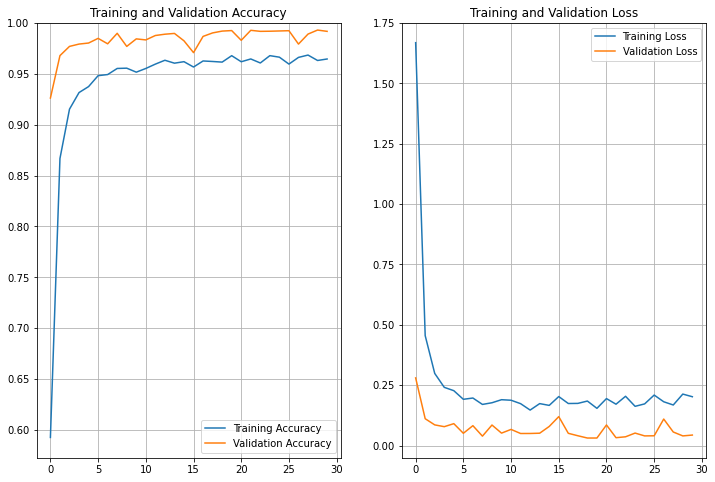

In [116]:
plot_history(history,metricname, valmetricname)

In [117]:
pred2 = np.argmax(model.predict(X_test), axis = 1)

In [118]:
accuracy_score(y_test, pred2)

0.9663499604117182

# Input image processing for MobileNetV2

In [136]:
train_images=[]
labels=[]
for i in range(num_classes):
    path=os.path.join(train_path,str(i))
    print(path)
    images=os.listdir(path)
    for image in images:
        try:
            image=Image.open(path+'/'+image)
            image=image.resize((224,224))
            train_images.append(np.array(image))
            labels.append(i)
        except AttributeError:
            print("Error",image)

/Users/davislab/Downloads/archive/Train/0
/Users/davislab/Downloads/archive/Train/1
/Users/davislab/Downloads/archive/Train/2
/Users/davislab/Downloads/archive/Train/3
/Users/davislab/Downloads/archive/Train/4
/Users/davislab/Downloads/archive/Train/5
/Users/davislab/Downloads/archive/Train/6
/Users/davislab/Downloads/archive/Train/7
/Users/davislab/Downloads/archive/Train/8
/Users/davislab/Downloads/archive/Train/9
/Users/davislab/Downloads/archive/Train/10
/Users/davislab/Downloads/archive/Train/11
/Users/davislab/Downloads/archive/Train/12
/Users/davislab/Downloads/archive/Train/13
/Users/davislab/Downloads/archive/Train/14
/Users/davislab/Downloads/archive/Train/15
/Users/davislab/Downloads/archive/Train/16
/Users/davislab/Downloads/archive/Train/17
/Users/davislab/Downloads/archive/Train/18
/Users/davislab/Downloads/archive/Train/19
/Users/davislab/Downloads/archive/Train/20
/Users/davislab/Downloads/archive/Train/21
/Users/davislab/Downloads/archive/Train/22
/Users/davislab/Downl

In [137]:
train_images=np.array(train_images)
labels=np.array(labels)

In [138]:
train_images.shape, labels.shape

((39209, 224, 224, 3), (39209,))

In [139]:
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.2, random_state=42, shuffle=True)

In [140]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((31367, 224, 224, 3), (7842, 224, 224, 3), (31367,), (7842,))

In [141]:
y_train = tf.keras.utils.to_categorical(y_train, 43)
y_val = tf.keras.utils.to_categorical(y_val,43)

In [142]:
img_shape=X_train[0].shape
img_shape

(224, 224, 3)

# Model 3: MobileNetV2

In [147]:
def create_mobilenetmodel1(numclasses, img_shape, metrics=['accuracy']):
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
    pretrained_model.trainable = False #True

    model = tf.keras.Sequential([
        pretrained_model,
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(numclasses, activation='softmax')
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.GlobalAveragePooling2D(),
        # tf.keras.layers.Dense(numclasses, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        #loss = 'sparse_categorical_crossentropy',
        metrics=metrics
    )

    return model

In [148]:
model=createCNNsimplemodel('mobilenetmodel1', num_classes, img_shape, metrics=['accuracy'])

In [149]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 43)                55083     
Total params: 2,313,067
Trainable params: 55,083
Non-trainable params: 2,257,984
_________________________________________________________________


In [151]:
start_time = time.time()
#train the model 
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=32, epochs=10, callbacks=callbacks)

Epoch 1/10
981/981 [==============================] - 491s 500ms/step - loss: 1.1593 - accuracy: 0.6431 - val_loss: 1.0996 - val_accuracy: 0.6547

Learning rate for epoch 1 is 0.0010000000474974513
Epoch 2/10
981/981 [==============================] - 499s 509ms/step - loss: 0.9742 - accuracy: 0.6996 - val_loss: 0.9409 - val_accuracy: 0.7066

Learning rate for epoch 2 is 0.0010000000474974513
Epoch 3/10
981/981 [==============================] - 488s 498ms/step - loss: 0.8613 - accuracy: 0.7319 - val_loss: 0.8802 - val_accuracy: 0.7195

Learning rate for epoch 3 is 0.0010000000474974513
Epoch 4/10
981/981 [==============================] - 492s 502ms/step - loss: 0.7431 - accuracy: 0.7777 - val_loss: 0.8010 - val_accuracy: 0.7547

Learning rate for epoch 4 is 9.999999747378752e-05
Epoch 5/10
981/981 [==============================] - 489s 498ms/step - loss: 0.7324 - accuracy: 0.7801 - val_loss: 0.7905 - val_accuracy: 0.7571

Learning rate for epoch 5 is 9.999999747378752e-05
Epoch 6/10

In [152]:
metricname='accuracy'
metrics=[metricname]
valmetricname="val_"+metricname
final_accuracy = history.history[valmetricname][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

FINAL ACCURACY MEAN-5:  0.761285376548767
TRAINING TIME:  4979.916841030121  sec


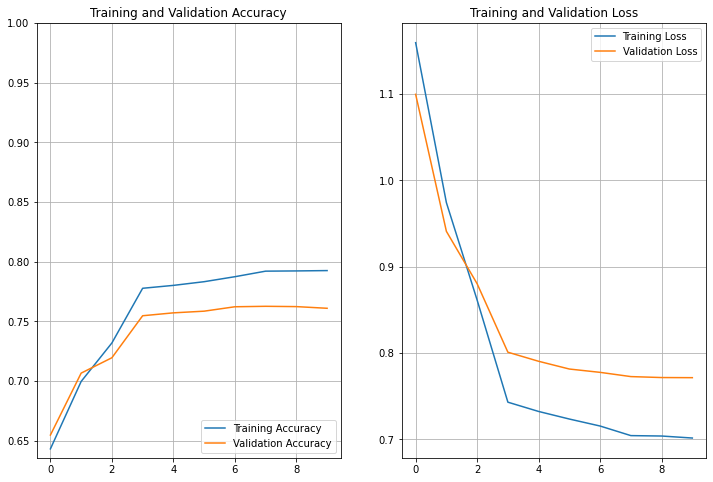

In [153]:
plot_history(history,metricname, valmetricname)

# Processing test image dimension

In [155]:
test_images=[]
folder="/Users/davislab/Downloads/archive/"
for i in test_labels:
    image=Image.open(folder+str(i))
    image=image.resize((224,224))
    test_images.append(np.array(image))

In [156]:
X_test=np.array(test_images)
pred3 = np.argmax(model.predict(X_test), axis = 1)

In [157]:
accuracy_score(y_test, pred3)

0.5904988123515439

In [158]:
X_train.shape[1:]

(224, 224, 3)

# Input image processing for CNN

In [162]:
train_images=[]
labels=[]
for i in range(num_classes):
    path=os.path.join(train_path,str(i))
    print(path)
    images=os.listdir(path)
    for image in images:
        try:
            image=Image.open(path+'/'+image)
            image=image.resize((32,32))
            train_images.append(np.array(image))
            labels.append(i)
        except AttributeError:
            print("Error",image)

/Users/davislab/Downloads/archive/Train/0
/Users/davislab/Downloads/archive/Train/1
/Users/davislab/Downloads/archive/Train/2
/Users/davislab/Downloads/archive/Train/3
/Users/davislab/Downloads/archive/Train/4
/Users/davislab/Downloads/archive/Train/5
/Users/davislab/Downloads/archive/Train/6
/Users/davislab/Downloads/archive/Train/7
/Users/davislab/Downloads/archive/Train/8
/Users/davislab/Downloads/archive/Train/9
/Users/davislab/Downloads/archive/Train/10
/Users/davislab/Downloads/archive/Train/11
/Users/davislab/Downloads/archive/Train/12
/Users/davislab/Downloads/archive/Train/13
/Users/davislab/Downloads/archive/Train/14
/Users/davislab/Downloads/archive/Train/15
/Users/davislab/Downloads/archive/Train/16
/Users/davislab/Downloads/archive/Train/17
/Users/davislab/Downloads/archive/Train/18
/Users/davislab/Downloads/archive/Train/19
/Users/davislab/Downloads/archive/Train/20
/Users/davislab/Downloads/archive/Train/21
/Users/davislab/Downloads/archive/Train/22
/Users/davislab/Downl

In [163]:
train_images=np.array(train_images)
labels=np.array(labels)

In [164]:
train_images.shape, labels.shape

((39209, 32, 32, 3), (39209,))

In [165]:
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.2, random_state=42, shuffle=True)

In [166]:
y_train = tf.keras.utils.to_categorical(y_train, 43)
y_val = tf.keras.utils.to_categorical(y_val,43)

# Model 4: CNN

In [179]:
model = Sequential()

#1st layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Dense layer
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(43, activation = 'softmax'))

In [180]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 64)        

In [183]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [184]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, validation_data=(X_val, y_val),callbacks=callbacks)

Epoch 1/20
981/981 [==============================] - 20s 20ms/step - loss: 0.4904 - accuracy: 0.8698 - val_loss: 0.1439 - val_accuracy: 0.9589

Learning rate for epoch 1 is 0.0010000000474974513
Epoch 2/20
981/981 [==============================] - 20s 20ms/step - loss: 0.4685 - accuracy: 0.8749 - val_loss: 0.1489 - val_accuracy: 0.9634

Learning rate for epoch 2 is 0.0010000000474974513
Epoch 3/20
981/981 [==============================] - 20s 20ms/step - loss: 0.4391 - accuracy: 0.8798 - val_loss: 0.1236 - val_accuracy: 0.9705

Learning rate for epoch 3 is 0.0010000000474974513
Epoch 4/20
981/981 [==============================] - 20s 20ms/step - loss: 0.3254 - accuracy: 0.9103 - val_loss: 0.0712 - val_accuracy: 0.9814

Learning rate for epoch 4 is 9.999999747378752e-05
Epoch 5/20
981/981 [==============================] - 20s 20ms/step - loss: 0.2472 - accuracy: 0.9331 - val_loss: 0.0611 - val_accuracy: 0.9855

Learning rate for epoch 5 is 9.999999747378752e-05
Epoch 6/20
981/981 [

In [185]:
metricname='accuracy'
metrics=[metricname]
valmetricname="val_"+metricname
final_accuracy = history.history[valmetricname][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

FINAL ACCURACY MEAN-5:  0.9883703112602233


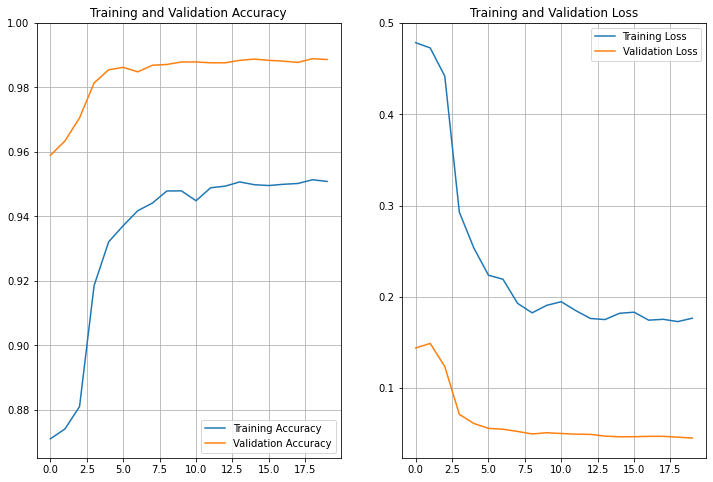

In [186]:
plot_history(history,metricname, valmetricname)

In [187]:
test_images=[]
folder="/Users/davislab/Downloads/archive/"
for i in test_labels:
    image=Image.open(folder+str(i))
    image=image.resize((32,32))
    test_images.append(np.array(image))

In [188]:
X_test=np.array(test_images)
pred4 = np.argmax(model.predict(X_test), axis = 1)

In [190]:
accuracy_score(y_test, pred4)

0.9638163103721299